In [2]:
import xarray as xr
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
path = '../../data/carra/'
files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.nc')]


In [7]:
ds_sst = xr.open_dataset(os.path.join(path, 'sea_surface_temperature.nc'))
ds_ist = xr.open_dataset(os.path.join(path, 'sea_ice_surface_temperature.nc'))
ds_skin = xr.open_dataset(os.path.join(path, 'skin_temperature.nc'))

ERA5_ist = xr.open_dataset(os.path.join('/projekt_agmwend/home_rad/Joshua/MasterArbeit/ERA5_reanalysis_ST.nc'))

In [9]:
basepath = '/projekt_agmwend/home_rad/Joshua/HALO-AC3_VELOX_sea_ice/'
files = [os.path.join(basepath, f) for f in os.listdir(basepath) if f.endswith('0.1_pred.nc')]
files.sort()

pred_2d_all = xr.concat([xr.open_dataset(file, engine='h5netcdf', chunks={'time' : 250, 'x' : 250, 'y' : 250}) for file in files], dim='time')


files = pd.read_csv('/projekt_agmwend/home_rad/Joshua/MasterArbeit/filenames.csv')['BAHAMAS'].tolist()

ds_bahamas = xr.concat([xr.open_dataset(file) for file in files], dim='tid').rename({'tid' : 'time'})
ds_bahamas = ds_bahamas.assign_coords({'TIME' : ds_bahamas.TIME.values}).rename({'TIME' : 'time'})

ds_bahamas = ds_bahamas.sel(time=pred_2d_all.time, method='nearest') 

pred_2d_all['lat'] = ('time', ds_bahamas.IRS_LAT.values)
pred_2d_all['lon'] = ('time', ds_bahamas.IRS_LON.values)

pred_2d_all[list(ds_bahamas.keys())] = ds_bahamas[list(ds_bahamas.keys())]


In [11]:
from haversine import haversine, Unit
from sklearn.neighbors import BallTree, KDTree


lat_slice = slice(77, 81)
lon_slice = slice(-5, 10)

condition = (pred_2d_all.lat > lat_slice.start) & (pred_2d_all.lat < lat_slice.stop) & (pred_2d_all.lon > lon_slice.start) & (pred_2d_all.lon < lon_slice.stop)

fram_strait = pred_2d_all.where(condition, drop=True)

ds_strong = fram_strait.sel(time='2022-04-01').sortby('time')
ds_weak = fram_strait.sel(time='2022-04-04').sortby('time')

ds_strong['rad_lat'] = np.deg2rad(ds_strong.lat)
ds_strong['rad_lon'] = np.deg2rad(ds_strong.lon)

ds_weak['rad_lat'] = np.deg2rad(ds_weak.lat)
ds_weak['rad_lon'] = np.deg2rad(ds_weak.lon)
ds_skin_stacked = ds_skin.stack(points=('x', 'y')).isel(time=0)
ds_skin_stacked['rad_lat'] = np.deg2rad(ds_skin.latitude)
ds_skin_stacked['rad_lon'] = np.deg2rad(ds_skin.longitude - 360)

ds_weak.lat.shape, ds_strong.lat.shape

### match lon and lat for both cases; find the closest point in the other dataset

from scipy.spatial import cKDTree

ball = BallTree(np.column_stack((ds_strong.rad_lat.values, ds_strong.rad_lon.values)), metric='haversine')

distances, indices = ball.query(np.column_stack((ds_weak.rad_lat.values, ds_weak.rad_lon.values)))

km_distances = distances * 6371

indices = indices[km_distances < 10]

unique, counts = np.unique(indices, return_counts=True)

unique_times = ds_strong.time.isel(time=unique)


ds_strong_matched = ds_strong.isel(time=indices)
ds_weak_matched = ds_weak

In [13]:
ERA5_ist

<xarray.Dataset>
Dimensions:    (longitude: 161, latitude: 49, time: 1464)
Coordinates:
  * longitude  (longitude) float32 -20.0 -19.75 -19.5 -19.25 ... 19.5 19.75 20.0
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 78.5 78.25 78.0
  * time       (time) datetime64[ns] 2022-03-01 ... 2022-04-30T23:00:00
Data variables:
    istl1      (time, latitude, longitude) float32 ...
    istl3      (time, latitude, longitude) float32 ...
    skt        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-09-22 12:30:56 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [23]:
MODIS = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/MODIS/MODIS_Aqua_Sea_Ice_Extent_and_IST_Daily_L3_Global_4km_EASE-Grid_Day_V061.nc')

MODIS_1 = MODIS.sel(time='2022-04-01')
MODIS_2 = MODIS.sel(time='2022-04-04')

CARRA_1 = ds_skin.sel(time='2022-04-01').mean('time')
CARRA_2 = ds_skin.sel(time='2022-04-04').mean('time')

ERA_1 = ERA5_ist.sel(time='2022-04-01').mean('time')
ERA_2 = ERA5_ist.sel(time='2022-04-04').mean('time')

lons = ds_weak.lon.values
lats = ds_weak.lat.values

result_ds = xr.Dataset(
    data_vars=dict(
        MODIS_skin_T_weak =(['time'], np.zeros(len(lons)) * np.nan),
        MODIS_skin_T_strong =(['time'], np.zeros(len(lons)) * np.nan),
        CARRA_skin_T_weak =(['time'], np.zeros(len(lons)) * np.nan),
        CARRA_skin_T_strong =(['time'], np.zeros(len(lons)) * np.nan),
        ERA5_skin_T_weak =(['time'], np.zeros(len(lons)) * np.nan),
        ERA5_skin_T_strong =(['time'], np.zeros(len(lons)) * np.nan),
        distance_to_carra=(['time'], np.zeros(len(lons))),
        distance_to_modis=(['time'], np.zeros(len(lons))),
        distance_to_era=(['time'], np.zeros(len(lons))),
        MODIS_lat=(['time'], np.zeros(len(lons))),
        MODIS_lon=(['time'], np.zeros(len(lons))),
        CARRA_lat=(['time'], np.zeros(len(lons))),
        CARRA_lon=(['time'], np.zeros(len(lons))),
        ERA5_lat=(['time'], np.zeros(len(lons))),
        ERA5_lon=(['time'], np.zeros(len(lons))),
    ),
    coords=dict(
        time=ds_weak.time.values,
    )
)

for subset, vel_sel, carra, era in zip([MODIS_1, MODIS_2], [ds_strong_matched, ds_weak], [CARRA_1, CARRA_2], [ERA_1, ERA_2]):

    lons = vel_sel.lon.values
    lats = vel_sel.lat.values
    fmt_time = subset.time.dt.strftime('%Y-%m-%d').values.item()

    for i, (lon, lat) in tqdm(enumerate(zip(lons, lats))):


        min_diff = ((carra.latitude - lat)**2 + (carra.longitude- 360 - lon)**2)**.5

        carra_y, carra_x = np.where(min_diff == min_diff.min())
        carra_sel = carra.isel(x=carra_x, y=carra_y)
        closest_lat_carra = carra_sel.latitude.values.flatten()[0]
        closest_lon_carra = carra_sel.longitude.values.flatten()[0] - 360
        closest_lat_modis = float(subset.lat.sel(lat=lat, method='nearest').values)
        closest_lon_modis = float(subset.lon.sel(lon=lon, method='nearest').values)
        closest_lat_era = float(era.latitude.sel(latitude=lat, method='nearest').values)
        closest_lon_era = float(era.longitude.sel(longitude=lon, method='nearest').values)

        lon = lon.astype(float)
        lat = lat.astype(float)


        distance_to_modis = haversine((lat, lon), (closest_lat_modis, closest_lon_modis), unit=Unit.KILOMETERS)
        mod_sst = subset.sel(lat=closest_lat_modis, lon=closest_lon_modis).IST.values.item()

        distance_to_carra = haversine((lat, lon), (closest_lat_carra, closest_lon_carra), unit=Unit.KILOMETERS)
        carra_skinT = carra_sel.skt.values.item()

        distance_to_era = haversine((lat, lon), (closest_lat_era, closest_lon_era), unit=Unit.KILOMETERS)
        era_skinT = era.sel(latitude=closest_lat_era, longitude=closest_lon_era).skt.values.item()

        result_ds['distance_to_carra'][i] = distance_to_carra
        result_ds['distance_to_modis'][i] = distance_to_modis
        result_ds['distance_to_era'][i] = distance_to_era
        result_ds['MODIS_lat'][i] = closest_lat_modis
        result_ds['MODIS_lon'][i] = closest_lon_modis
        result_ds['CARRA_lat'][i] = closest_lat_carra  
        result_ds['CARRA_lon'][i] = closest_lon_carra
        result_ds['ERA5_lat'][i] = closest_lat_era
        result_ds['ERA5_lon'][i] = closest_lon_era


        if (distance_to_modis < 5) & ~np.isnan(mod_sst):

            if fmt_time == '2022-04-01':
                result_ds['MODIS_skin_T_strong'][i] = mod_sst - 273.15

            if fmt_time == '2022-04-04':
                result_ds['MODIS_skin_T_weak'][i] = mod_sst - 273.15

        if (distance_to_carra < 5) & ~np.isnan(carra_skinT):
            
            if fmt_time == '2022-04-01':
                result_ds['CARRA_skin_T_strong'][i] = carra_skinT - 273.15

            if fmt_time == '2022-04-04':
                result_ds['CARRA_skin_T_weak'][i] = carra_skinT - 273.15

        if (distance_to_era < 5) & ~np.isnan(era_skinT):
            
            if fmt_time == '2022-04-01':
                result_ds['ERA5_skin_T_strong'][i] = era_skinT - 273.15

            if fmt_time == '2022-04-04':
                result_ds['ERA5_skin_T_weak'][i] = era_skinT - 273.15

0it [00:00, ?it/s]

3039it [00:50, 60.39it/s]
3113it [00:49, 62.56it/s]


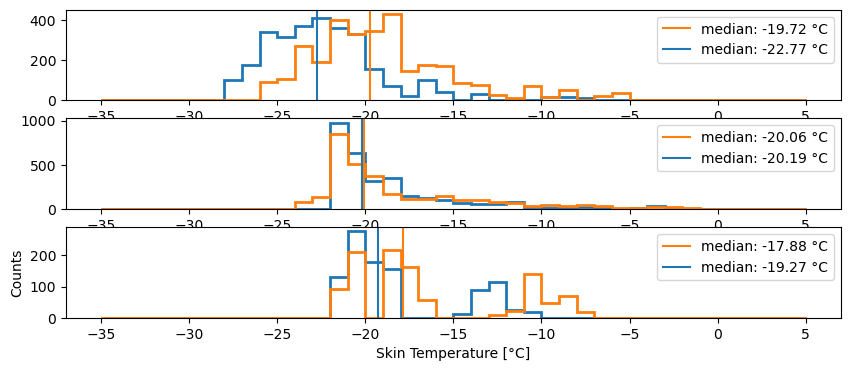

In [24]:
fig, ax = plt.subplots(3, figsize=(10, 4))

bins = np.linspace(-35, 5, 41)

result_ds['MODIS_skin_T_strong'].plot.hist(bins=bins,  histtype='step', ls='-', lw=2, ax=ax[0])
result_ds['MODIS_skin_T_weak'].plot.hist(bins=bins, histtype='step', ls='-', lw=2, ax=ax[0])

MODIS_weak_median = result_ds['MODIS_skin_T_weak'].median().values
MODIS_strong_median = result_ds['MODIS_skin_T_strong'].median().values

ax[0].axvline(MODIS_weak_median, color='C1', label=f'median: {MODIS_weak_median:.2f} °C', ls='-')
ax[0].axvline(MODIS_strong_median, color='C0', label=f'median: {MODIS_strong_median:.2f} °C', ls='-')

result_ds['CARRA_skin_T_strong'].plot.hist(bins=bins, histtype='step', ls='-', lw=2, ax=ax[1])
result_ds['CARRA_skin_T_weak'].plot.hist(bins=bins, histtype='step', ls='-', lw=2, ax=ax[1])

CARRA_weak_median = result_ds['CARRA_skin_T_weak'].median().values
CARRA_strong_median = result_ds['CARRA_skin_T_strong'].median().values

ax[1].axvline(CARRA_weak_median, color='C1', label=f'median: {CARRA_weak_median:.2f} °C', ls='-',)
ax[1].axvline(CARRA_strong_median, color='C0', label=f'median: {CARRA_strong_median:.2f} °C', ls='-')

result_ds['ERA5_skin_T_strong'].plot.hist(bins=bins, histtype='step', ls='-', lw=2, ax=ax[2])
result_ds['ERA5_skin_T_weak'].plot.hist(bins=bins, histtype='step', ls='-', lw=2, ax=ax[2])

ERA5_weak_median = result_ds['ERA5_skin_T_weak'].median().values
ERA5_strong_median = result_ds['ERA5_skin_T_strong'].median().values

ax[2].axvline(ERA5_weak_median, color='C1', label=f'median: {ERA5_weak_median:.2f} °C', ls='-')
ax[2].axvline(ERA5_strong_median, color='C0', label=f'median: {ERA5_strong_median:.2f} °C', ls='-')

ax[2].set_xlabel('Skin Temperature [°C]')
ax[2].set_ylabel('Counts')
ax[2].legend()
ax[0].legend()
ax[1].legend()

weak: 978712800, strong: 957464430


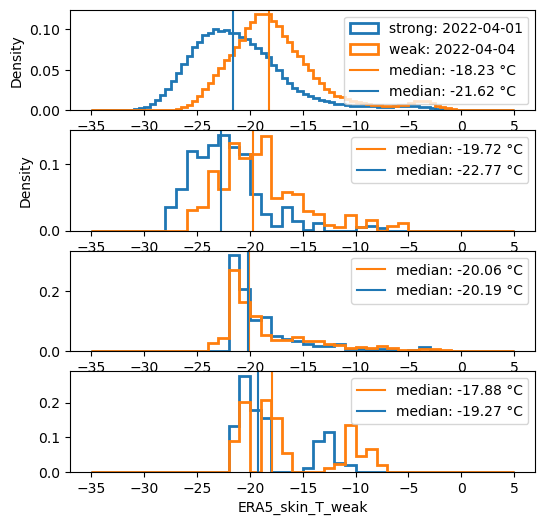

In [20]:
fig, (ax, ax2, ax3, ax4) = plt.subplots(4, figsize=(6, 6))
bins = np.linspace(-35, 5, 81)

ds_strong_matched['T_skin'].plot.hist(bins=bins, label='strong: 2022-04-01', histtype='step', ax=ax, lw=2, color='C0', density=1)
ds_weak['T_skin'].plot.hist(bins=bins, label='weak: 2022-04-04', histtype='step', ax=ax, lw=2, color='C1', density=1)


median_weak = np.nanmedian(ds_weak['T_skin'].values)
median_strong = np.nanmedian(ds_strong_matched['T_skin'].values)

ax.axvline(median_weak, color='C1', label=f'median: {median_weak:.2f} °C')
ax.axvline(median_strong, color='C0', label=f'median: {median_strong:.2f} °C')


ax.legend(loc='upper right')

total_counts_weak = ds_weak['T_skin'].count().values

total_counts_strong = ds_strong_matched['T_skin'].count().values

bins = np.linspace(-35, 5, 41)


print(f'weak: {total_counts_weak}, strong: {total_counts_strong}')

result_ds['MODIS_skin_T_strong'].plot.hist(bins=bins,  histtype='step', lw=2, density=1, ax=ax2)
result_ds['MODIS_skin_T_weak'].plot.hist(bins=bins, histtype='step', lw=2, density=1, ax=ax2)

MODIS_weak_median = result_ds['MODIS_skin_T_weak'].median().values
MODIS_strong_median = result_ds['MODIS_skin_T_strong'].median().values

ax2.axvline(MODIS_weak_median, color='C1', label=f'median: {MODIS_weak_median:.2f} °C')
ax2.axvline(MODIS_strong_median, color='C0', label=f'median: {MODIS_strong_median:.2f} °C')

ax2.set_xlabel(r'$T_\mathrm{skin}$ [°C]')

ax.set_ylabel('Density')
ax2.set_ylabel('Density')

result_ds['CARRA_skin_T_strong'].plot.hist(bins=bins, histtype='step', lw=2, color='C0', density=1, ax=ax3)
result_ds['CARRA_skin_T_weak'].plot.hist(bins=bins, histtype='step', lw=2, color='C1', density=1, ax=ax3)

CARRA_weak_median = result_ds['CARRA_skin_T_weak'].median().values
CARRA_strong_median = result_ds['CARRA_skin_T_strong'].median().values

ax3.axvline(CARRA_weak_median, color='C1', label=f'median: {CARRA_weak_median:.2f} °C')
ax3.axvline(CARRA_strong_median, color='C0', label=f'median: {CARRA_strong_median:.2f} °C')

result_ds['ERA5_skin_T_strong'].plot.hist(bins=bins, histtype='step', lw=2, color='C0', density=1, ax=ax4)
result_ds['ERA5_skin_T_weak'].plot.hist(bins=bins, histtype='step', lw=2, color='C1', density=1, ax=ax4)

ERA5_weak_median = result_ds['ERA5_skin_T_weak'].median().values
ERA5_strong_median = result_ds['ERA5_skin_T_strong'].median().values

ax4.axvline(ERA5_weak_median, color='C1', label=f'median: {ERA5_weak_median:.2f} °C')
ax4.axvline(ERA5_strong_median, color='C0', label=f'median: {ERA5_strong_median:.2f} °C')


ax2.legend(loc='upper right')
ax3.legend(loc='upper right')
ax4.legend(loc='upper right')

plt.savefig('../../plots/weak_strong_hist_velox_modis_carra_era.png', dpi=300, bbox_inches='tight')

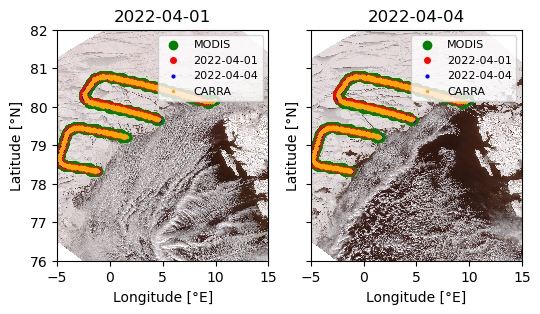

In [131]:
### plot all tracks together to make sure that the matching is correct

ds1 = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/Mueller_et_al_2024/data/satellite/snapshot-2022-04-01T00_00_00Z.tif', engine='rasterio')
ds2 = xr.open_dataset('/projekt_agmwend/home_rad/Joshua/Mueller_et_al_2024/data/satellite/snapshot-2022-04-04T00_00_00Z.tif', engine='rasterio')

ds_reprojected = ds2.rio.reproject('EPSG:4326', resolution=0.005)
ds_reprojected_2 = ds_reprojected.where(ds_reprojected < 256) / 256


ds_reprojected = ds1.rio.reproject('EPSG:4326', resolution=0.005)
ds_reprojected_1 = ds_reprojected.where(ds_reprojected < 256) / 256


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

ds_reprojected_1.isel(band=[2,1,0]).band_data.plot.imshow(cmap='viridis', vmin=0, vmax=1, ax=ax1)
ds_reprojected_2.isel(band=[2,1,0]).band_data.plot.imshow(cmap='viridis', vmin=0, vmax=1, ax=ax2)

title = ['2022-04-01', '2022-04-04']

for ax in (ax1, ax2):

    ax.set_xlim(-5, 15)
    ax.set_ylim(76, 82)
    ax.scatter(result_ds['MODIS_lon'], result_ds['MODIS_lat'], c='g', label='MODIS', alpha=1, s=36)
    ax.scatter(ds_strong_matched.lon, ds_strong_matched.lat, c='r', label='2022-04-01', alpha=1, marker='o' ,s=16)
    ax.scatter(ds_weak.lon, ds_weak.lat, c='b', label='2022-04-04', alpha=1, s=4)
    ax.scatter(result_ds['CARRA_lon'], result_ds['CARRA_lat'], c='orange', label='CARRA', alpha=1, s=2)


    ax.set_title(title.pop(0))
    ax.set_xlabel('Longitude [°E]')
    ax.set_ylabel('Latitude [°N]')

    ax.legend(loc='upper right', fontsize=8)

plt.savefig('../../plots/weak_strong_satellite_with_modis_and_carra.png', dpi=300, bbox_inches='tight')

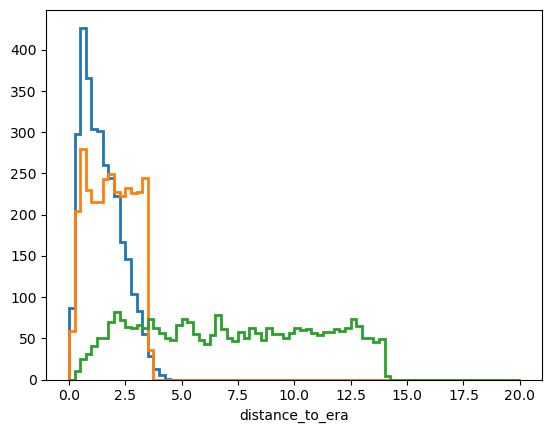

In [28]:
result_ds['distance_to_carra'].plot.hist(bins=np.linspace(0, 20, 81), histtype='step', lw=2, label='CARRA')
result_ds['distance_to_modis'].plot.hist(bins=np.linspace(0, 20, 81), histtype='step', lw=2, label='MODIS')
result_ds['distance_to_era'].plot.hist(bins=np.linspace(0, 20, 81), histtype='step', lw=2, label='ERA5')

plt.show()